In [63]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
import tensorflow as tf

from helper import *
from connection import *

# build training data

In [64]:
# import data
df = pd.read_csv("data/test_dataset_no_missing_2.csv")
data = df.to_numpy()

In [65]:
(l, w) = data.shape
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0: 
            x_train[i, d*2] = p # 0 score
            x_train[i, d*2+1] = p # missing indicator
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score
x_train

array([[0.78208023, 0.21791977, 0.3816844 , 0.6183156 ],
       [0.39358905, 0.60641095, 0.31200055, 0.68799945],
       [0.0572248 , 0.9427752 , 0.78475412, 0.21524588],
       ...,
       [0.25542948, 0.74457052, 0.88261002, 0.11738998],
       [0.6164064 , 0.3835936 , 0.15777525, 0.84222475],
       [0.89770934, 0.10229066, 0.6429232 , 0.3570768 ]])

In [66]:
from sklearn.metrics import mean_squared_error

# @tf.function
def custom_mse(y_true, y_pred):
    # print("here")
    # ground = np.zeros(y_true.shape)
    # pred = y_pred.numpy()
    # n_domain = 2
    # for row in range(len(ground)):
    #     for i in range(n_domain):
    #         if y_true[row, i*2] == 0 and y_true[row, i*2+1] == 0:
    #             print("here")
    #             ground[row, i*2] = pred[row, i*2] + 0.1
    #             ground[row, i*2+1] = pred[row, i*2+1] + 0.1
    #         else:
    #             ground[row, i*2] = y_true[row, i*2]
    #             ground[row, i*2+1] = y_true[row, i*2+1]
    
    # print(mse)
    with tf.GradientTape() as tape:
        mse = mean_squared_error(y_pred, y_true)
        
    grads = tape.gradient(mse, y_true)
	opt.apply_gradients(zip(grads, y_true))
    return mse
    # ground = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    # pred = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    # n_domain = 2
    # for row in range(len(y_true)):
    #     new_row = []
    #     for i in range(n_domain):
    #         # if missing, then modify target
    #         if y_true[row, i*2] == 0 and y_true[row, i*2+1] == 0:
    #             new_row.append(y_pred[row, i*2])
    #             new_row.append(y_pred[row, i*2+1])
    #         else:
    #             new_row.append(y_true[row, i*2])
    #             new_row.append(y_true[row, i*2+1])
    #     ground = ground.write(row, new_row)
    #     pred = pred.write(row, y_pred[row])

    # # ground = tf.convert_to_tensor(ground)
    # # pred = tf.convert_to_tensor(pred)
    # print(pred)
    # print(ground)

    # return tf.reduce_mean(tf.math.squared_difference(tf.cast(pred, tf.float32), tf.cast(ground, tf.float32)))

# Simple Autoencoder

In [67]:
## build autoencoder
from keras import layers

n_domain = w # number of domains

encoding_dim = 1
## input n_domain * 2 to represent missing values
input_layer = keras.Input(shape=(n_domain * 2,))
encode_layer = layers.Dense(encoding_dim, activation="relu")(input_layer)
decode_layer = layers.Dense(n_domain * 2, activation="sigmoid")(encode_layer)

autoencoder = keras.Model(input_layer, decode_layer)

In [68]:
# build encoder and decoder model
encoder = keras.Model(input_layer, encode_layer)
encoded_input = keras.Input(shape=(encoding_dim,))
decode_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decode_layer(encoded_input))

In [69]:
# compile with optimizer and loss function
autoencoder.compile(optimizer="adam", loss=custom_mse, run_eagerly=True)

### Training

In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x_train, test_size=0.20, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.25, random_state=42)

In [71]:
test_case = np.array([[0, 0, 1, 0]])

In [72]:
x_test_encoded = encoder.predict(test_case, batch_size=256)
x_decoded = decoder.predict(x_test_encoded)

1/1 [==============================] - 0s 21ms/step


In [73]:
x_test_encoded
x_decoded

array([[0.5, 0.5, 0.5, 0.5]], dtype=float32)

In [74]:
# custom_mse(test_case, x_decoded)

In [75]:
output = autoencoder.fit(x = x_train, y = x_train,
                epochs=500,
                batch_size=1,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/500


ValueError: No gradients provided for any variable: (['dense_10/kernel:0', 'dense_10/bias:0', 'dense_11/kernel:0', 'dense_11/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_10/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.08216476],
       [ 1.0656536 ],
       [-0.27173638],
       [ 0.7902583 ]], dtype=float32)>), (None, <tf.Variable 'dense_10/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>), (None, <tf.Variable 'dense_11/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.01872778, -0.38015175, -1.0917088 , -0.5939489 ]],
      dtype=float32)>), (None, <tf.Variable 'dense_11/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>)).

### Evaluation

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=256)

1/1 [==============================] - 0s 8ms/step


In [ ]:
x_decoded = decoder.predict(x_test_encoded)

4/4 [==============================] - 0s 784us/step


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
mean_absolute_error(x_test, x_decoded, multioutput="raw_values")

array([0.22166746, 0.2215287 , 0.09399757, 0.1030815 ])

In [ ]:
mean_absolute_error(x_test, x_decoded)

0.16006880902751305

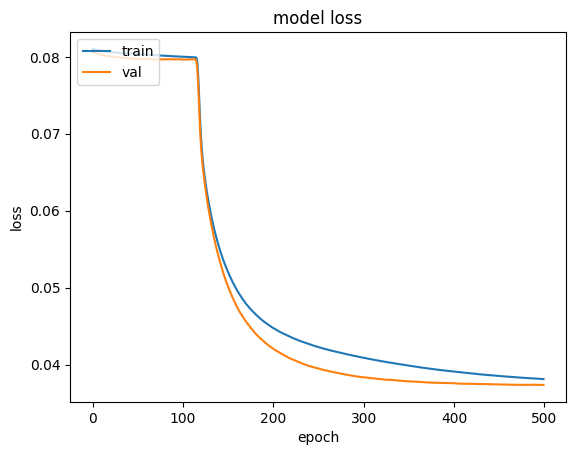

In [ ]:
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## all zero test case, expecting it to return averages

all_zeros = np.zeros((1, 4))
all_zeros_encoded = encoder.predict(all_zeros)
all_zeros_decoded = decoder.predict(all_zeros_encoded)
all_zeros_decoded

1/1 [==============================] - 0s 10ms/step


array([[0.53411585, 0.46574932, 0.31580558, 0.68357104]], dtype=float32)

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
all_zeros_decoded

array([[0.534116, 0.465749, 0.315806, 0.683571]], dtype=float32)

In [ ]:
x_train.mean(axis=0)

array([0.466631, 0.486703, 0.445332, 0.491335])